In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline





Text(0.5, 0, 'time')

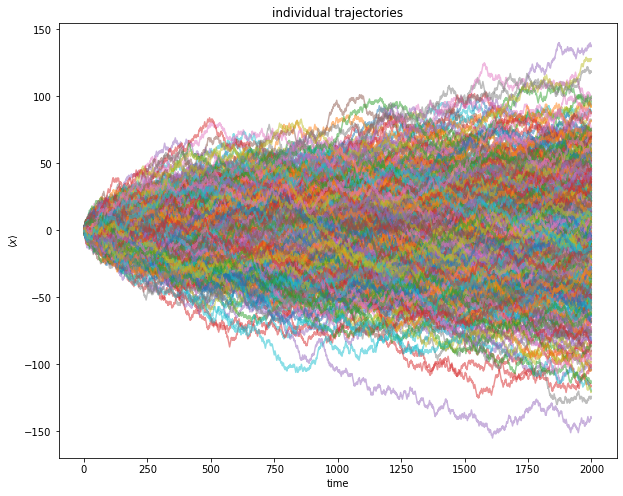

In [2]:
numtrajs = 500
numsteps = 2000
times = range(numsteps)
steps = np.random.random((numtrajs,numsteps))
steps[steps>0.5] = 1
steps[steps<=0.5] = -1
trajs = np.cumsum(steps,axis=1)
plt.figure(figsize = (10,8))
for traj in trajs:
    plt.plot(times,traj,alpha=0.5)
plt.title('individual trajectories')
plt.ylabel(r'$\left<x\right>$')
plt.xlabel('time')

In [3]:
#Parameters for the Brome Mosaic Virus
m = 7.6e-21      # kg
gamma = 3.4e10   # s^-1
dt = 10e-9       # s
T = 300          # K

kB = 1.380649e-23 # J/K

max_steps = 10000
x0 = 0           # m

sigma = np.sqrt(2*kB*T * dt / (m * gamma))  # m 

To account for the right size for the fluctuations, the random force must be uncorrelated Gaussian noise with zero mean and variance 
$$\sigma^2 = \frac{2 k_B T \Delta t}{m \gamma}$$

### Generating random numbers with numpy
How to generate Gaussian random displacements, i.e. normally distributed random numbers?
[numpy's random number generation](https://https://numpy.org/doc/stable/reference/random/index.html)

In [4]:
rng = np.random.default_rng()
steps = rng.normal(loc=0, scale=sigma, size=max_steps)

In [5]:
steps

array([ 6.55766239e-10, -6.64971530e-10,  2.02185106e-10, ...,
        6.67752212e-10,  3.62332965e-10,  6.93342390e-11])

In [6]:
x_trajectory = x0 + np.cumsum(steps)

In [7]:
x_trajectory

array([ 6.55766239e-10, -9.20529093e-12,  1.92979815e-10, ...,
        7.36390274e-08,  7.40013604e-08,  7.40706946e-08])

In [8]:
times = dt * np.arange(len(x_trajectory))

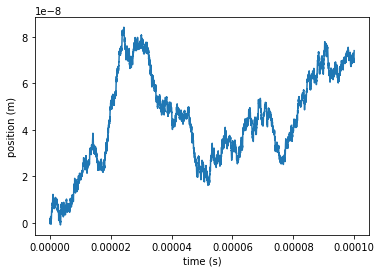

In [9]:


plt.plot(times, x_trajectory)
plt.xlabel("time (s)")
plt.ylabel("position (m)");



In [10]:
N_repeats = 100

In [11]:
steps = rng.normal(loc=0, scale=sigma, size=(N_repeats, max_steps))

In [12]:


x_trajectories = x0 + np.cumsum(steps, axis=1)

print(np.shape(x_trajectories))

(100, 10000)


(10000,) (10000, 100)


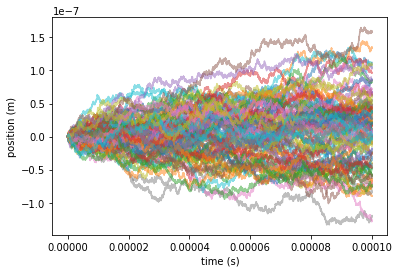

In [13]:
times = dt * np.arange(x_trajectories.shape[1])
print(np.shape(times), np.shape(x_trajectories.T))
plt.plot(times, x_trajectories.T, alpha=0.5);
plt.xlabel("time (s)")
plt.ylabel("position (m)");

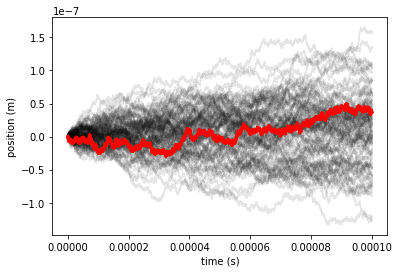

In [14]:
times = dt * np.arange(x_trajectories.shape[1])
plt.plot(times, x_trajectories.T, color="black", alpha=0.1);
plt.plot(times, x_trajectories[0], color="red", linewidth=3);
plt.xlabel("time (s)")
plt.ylabel("position (m)")
plt.savefig("diffusion_trajectories.png")

In [15]:
x_mean = x_trajectories.mean(axis=0)

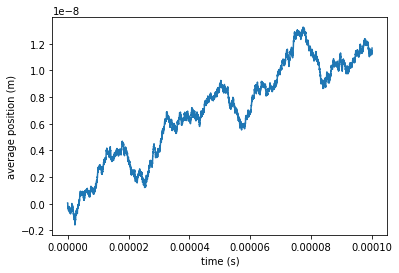

In [16]:
plt.plot(times, x_mean)
plt.xlabel("time (s)")
plt.ylabel("average position (m)");

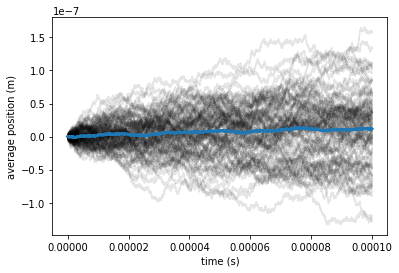

In [17]:
plt.plot(times, x_trajectories.T, alpha=0.1, color="black")
plt.plot(times, x_mean, linewidth=3)
plt.xlabel("time (s)")
plt.ylabel("average position (m)");

For a single trajectory, the $d^2(t)$ is noisy:

In [18]:


D2 = (x_trajectory - x0)**2



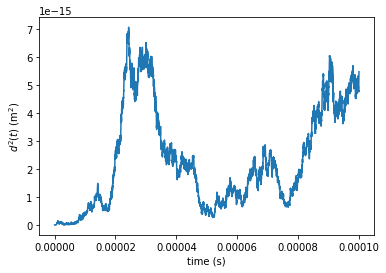

In [19]:
plt.plot(times, D2)
plt.xlabel("time (s)")
plt.ylabel(r"$d^2(t)$ (m$^2$)");

In [20]:
MSD = np.mean((x_trajectories - x0)**2, axis=0)

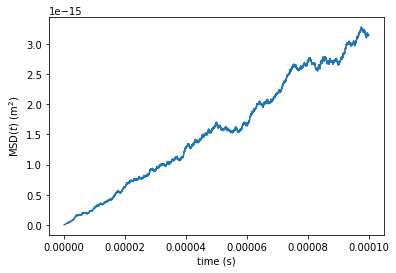

In [21]:
plt.plot(times, MSD)
plt.xlabel("time (s)")
plt.ylabel(r"$\mathrm{MSD}(t)$ (m$^2$)");

The MSD is approximately linear with time, as given by the Einstein diffusion equation (in 1D)
$$\lim_{t\rightarrow\infty} \text{MSD}(t) =  2 D t$$
With the [Einstein relation](https://en.wikipedia.org/wiki/Einstein_relation_(kinetic_theory)) (also: a fluctation-dissipation theorem for diffusion coefficient D and drag coefficient ζ)
$$D = \frac{kT}{\zeta} \quad\text{and}\quad \zeta = m\gamma$$
we can plot the theoretical MSD.

In [22]:
D = kB * T / (m * gamma)
print(D)

1.6029206656346748e-11


In [23]:
MSD_theory = 2 * D * times

Simulation and theoretical MSD plotted together:

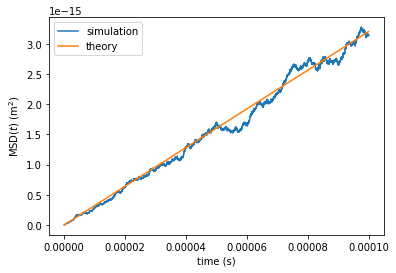

In [24]:
plt.plot(times, MSD, label="simulation")
plt.plot(times, MSD_theory, label="theory")
plt.xlabel("time (s)")
plt.ylabel(r"$\mathrm{MSD}(t)$ (m$^2$)")
plt.legend();


3.217757967042823e-11
-4.18854670468752e-17


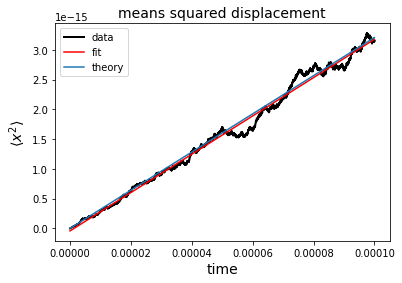

In [25]:
from scipy.optimize import curve_fit
def msd(x, m, c):
    return m*x+c

parameters, covariance = curve_fit(msd, times, MSD)
fit_m = parameters[0]
fit_c = parameters[1]
print(fit_m)
print(fit_c)
fit_y = msd(times, fit_m, fit_c)
plt.plot(times,MSD , linestyle ='-',label='data', lw = 2, color = 'black')
plt.plot(times, fit_y, '-', label='fit', color = 'red')
plt.plot(times, MSD_theory, label="theory")
plt.title('means squared displacement', fontsize = 14)
plt.ylabel(r'$\left<x^2\right>$', fontsize = 14)
plt.xlabel('time', fontsize = 14)
plt.legend()


### Fitting the simulation plot into a straight line given by $MSD = 2Dt$

In [26]:
from scipy.optimize import curve_fit
def msd(t, D):
    return 2*D*t

parameters, covariance = curve_fit(msd, times, MSD)
D_fit = parameters[0]


In [27]:
D_fit

1.5774633124534736e-11

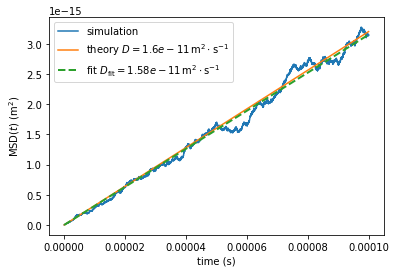

In [28]:
MSD_fit = msd(times, D_fit)
plt.plot(times, MSD, label="simulation")
plt.plot(times, MSD_theory, label=r"theory $D={0:.3g}\,\mathrm{{m}}^2\cdot\mathrm{{s}}^{{-1}}$".format(D))
plt.plot(times, MSD_fit, linestyle="--", linewidth=2,
         label=r"fit $D_\mathrm{{fit}}={0:.3g}\,\mathrm{{m}}^2\cdot\mathrm{{s}}^{{-1}}$".format(D_fit))
plt.xlabel("time (s)")
plt.ylabel(r"$\mathrm{MSD}(t)$ (m$^2$)")
plt.legend()

## Q1
There is still some significant difference between our theoretical value for D and our fitted D. Think, how can we get our D closer to the theoretical value? Increase the number of trajectories? Increase the length of trajectories?

In [29]:
#Parameters for the Brome Mosaic Virus
m = 7.6e-21      # kg
gamma = 3.4e10   # s^-1
dt = 10e-9       # s
T = 300          # K

kB = 1.380649e-23 # J/K

#max_steps = 10000
#x0 = 0           # m

D = kB * T / (m * gamma)
sigma = np.sqrt(2*kB*T * dt / (m * gamma))  # m 
rng = np.random.default_rng()

In [30]:
def simulated(N_repeats, max_steps, x0, plot):
    steps = rng.normal(loc=0, scale=sigma, size=(N_repeats, max_steps))
    x_trajectories = x0 + np.cumsum(steps, axis=1)
    times = dt * np.arange(x_trajectories.shape[1])
    x_mean = x_trajectories.mean(axis=0)
    
    if plot==True:
        fig = plt.figure(figsize=(8,5))
        plt.title(f'Random walk plots for {N_repeats} trajectories and {max_steps} steps')

        plt.plot(times, x_trajectories.T, color="black", alpha=0.1)
        plt.plot(times, x_mean, linewidth=3, label='Average position (m)')
        plt.xlabel("time (s)")
        plt.ylabel("position (m)")
        plt.legend()
        plt.show()

    
    
    MSD = np.mean((x_trajectories - x0)**2, axis=0)
    
    MSD_theory = 2 * D * times
    d=25
    m,c,SE, R2=linear_fit(times,MSD,d,False)  
    MSD_fit = m*times+c
    print(f"The theoretical value of D= {D} and the estimated value of D from the slope of fitted line (m/2)= {m/2}")
    print("Therefore, absolute percentage error in D= ", 100*abs((D-m/2)/D), "%")
    return times, MSD, MSD_theory, MSD_fit, m/2, 100*abs((D-m/2)/D)
                  
    

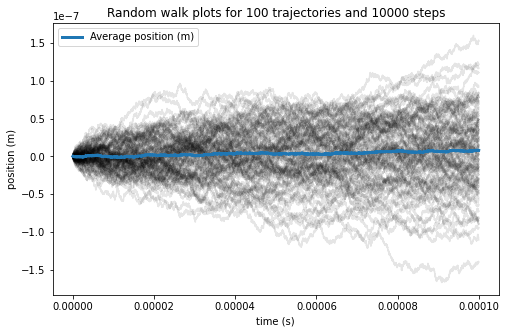

Did not converge to the required precision using Gauss Siedel method. Breaking after 1000 iterations.
Cramer's rule results in c=1.1877395800000002e-16 and m=2.6553789323563204e-11
The standard error of estimate is 1.12151523320459e-16 and the coefficient of determination is 0.9790465723295158
The theoretical value of D= 1.6029206656346748e-11 and the estimated value of D from the slope of fitted line (m/2)= 1.3276894661781602e-11
Therefore, absolute percentage error in D=  17.170606465887513 %


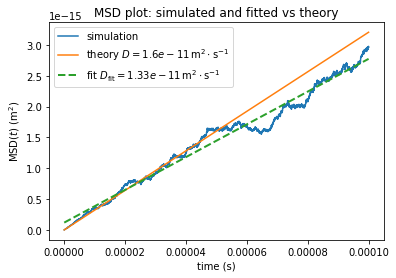

In [39]:
times, MSD, MSD_theory, MSD_fit, D_fit, err =simulated(100, 10000, 0, True)

plt.title('MSD plot: simulated and fitted vs theory')
plt.plot(times, MSD, label="simulation")
plt.plot(times, MSD_theory, label=r"theory $D={0:.3g}\,\mathrm{{m}}^2\cdot\mathrm{{s}}^{{-1}}$".format(D))
plt.plot(times, MSD_fit, linestyle="--", linewidth=2,
         label=r"fit $D_\mathrm{{fit}}={0:.3g}\,\mathrm{{m}}^2\cdot\mathrm{{s}}^{{-1}}$".format(D_fit))
plt.xlabel("time (s)")
plt.ylabel(r"$\mathrm{MSD}(t)$ (m$^2$)")
plt.legend()
plt.show()
    

Changing total number of steps



For 1000 steps:

Did not converge to the required precision using Gauss Siedel method. Breaking after 1000 iterations.
Cramer's rule results in c=-4.26616433e-17 and m=3.29255611319578e-11
The standard error of estimate is 3.1384583308175005e-17 and the coefficient of determination is 0.9018657761631608
The theoretical value of D= 1.6029206656346748e-11 and the estimated value of D from the slope of fitted line (m/2)= 1.64627805659789e-11
Therefore, absolute percentage error in D=  2.7048993685565863 %

For 2000 steps:

Did not converge to the required precision using Gauss Siedel method. Breaking after 1000 iterations.
Cramer's rule results in c=6.43835988e-17 and m=3.1401081370289605e-11
The standard error of estimate is 8.2754615123306e-17 and the coefficient of determination is 0.8277099275943722
The theoretical value of D= 1.6029206656346748e-11 and the estimated value of D from the slope of fitted line (m/2)= 1.5700540685144802e-11
Therefore, abs

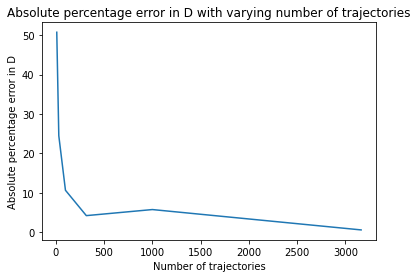

In [41]:
trajectories=10
steps=1000
times=[]
MSD=[]
MSD_theory=[]
MSD_fit=[]
D_fit=[]
abs_percentage_err=[]

#Changing total number of steps
print("Changing total number of steps\n\n")
for i in range(1,11):
    print(f"\nFor {steps*i} steps:\n")
    timesval, MSDval, MSD_theoryval, MSD_fitval, D_fitval, errval =simulated(trajectories, steps*i, 0, False)
    
X=[]    
#Changing number of trajectories 
print("\n\nChanging number of trajectories:\n\n")
for i in range(0,6):
    xval=int(trajectories*10**(i/2))
    print(f"\nFor {xval} trajectories:\n")
    timesval, MSDval, MSD_theoryval, MSD_fitval, D_fitval, errval =simulated(xval, steps, 0, False)
    times.append(timesval)
    MSD.append(MSDval)
    MSD_theory.append(MSD_theoryval)
    MSD_fit.append(MSD_fitval)
    D_fit.append(D_fitval)
    abs_percentage_err.append(errval)
    X.append(xval)

plt.title('Absolute percentage error in D with varying number of trajectories')
plt.plot(X,abs_percentage_err)
plt.xlabel('Number of trajectories')
plt.ylabel('Absolute percentage error in D')
plt.show()
    

Therefore, we can see that, on changing the number of steps, the error in D changes randomly but on increasing the number of trajectories, we get more and more closer fit to the theoretical value of D.

## Q2
Regression Analysis.

# Writing own regression/linear curve fitting code:

### Derivation of Normal equations (Least square method):
Let $X$ and $Y$ be the two linearly related variables i.e, assuming $Y$ dependent on $X$; the predicted model is: $$\hat Y=mX+c$$ Where, $\hat {Y}$ is the predicted $Y$ from the model. We need to determine parameters $m$ and $c$ to describe the model.

We have a data table of $X$ and corresponding $Y$ columns with $n$ rows. Let $x_i$ be the $i^{th}$ data value of $X$, and $y_i$ and $\hat {y_i}=mx_i+c$ be the corresponding $Y$ value in the table and corresponding predicted $\hat Y$ values (using the linear model), respectively for $i \in \{0,1,..., (n-1)\}$. Let us define error in our model as, $$E=(Y- \hat Y)$$ and $e_i=(y_i-\hat {y_i})$ be the $i^{th}$ error.

We can now calculate the mean of $X$ and $Y$ from the table as, $\bar X= \frac{\sum_{i=0}^{n-1} x_i}{n}$ and $\bar Y= \frac{\sum_{i=0}^{n-1} y_i}{n}$, respectively.

Assuming our predicted or fitted straight line passes through $(\bar X, \bar Y)$, i.e, when $X=\bar X$, $\hat Y=\bar Y$, $$ \frac{\sum_{i=0}^{n-1} y_i}{n}=\frac{\sum_{i=0}^{n-1} \hat{y_i}}{n} \implies \sum_{i=0}^{n-1} y_i=\sum_{i=0}^{n-1} \hat{y_i}$$ 

Since we are interested in the total error $\sum E$ of our model, the total error is then, $$\sum E=\sum_{i=0}^{n-1} e_i=\sum_{i=0}^{n-1} (y_i-\hat {y_i})= \sum_{i=0}^{n-1}y_i-\sum_{i=0}^{n-1}\hat {y_i}=0$$

Our goal is to find the parameters $m$ and $c$ such that we minimize the error value. So, the total error $\sum E$ has to be expressed in terms of $m$ and $c$. Since $\sum E$ is always $0$, it cannot be expressed in terms of $m$ and $c$ we minimize the Root Mean Squared $(RMSE)$ error or simply its square i.e. Mean Squared Error $(MSE= RMSE^2)$ or even simply by Sum of Squared errors $(SSE = n\times MSE= \sum E^2)$. We calculate $SSE$ and express it in terms of $m$ and $c$ as,
$$\sum E^2=\sum_{i=0}^{n-1} e_i^2=\sum_{i=0}^{n-1} (y_i-\hat {y_i})^2= \sum_{i=0}^{n-1} (y_i^2-2y_i\hat {y_i}+\hat {y_i}^2)=\sum_{i=0}^{n-1} y_i^2-2\sum_{i=0}^{n-1}y_i\hat {y_i}+\sum_{i=0}^{n-1}\hat {y_i}^2$$ $$=\sum_{i=0}^{n-1} y_i^2-2\sum_{i=0}^{n-1}y_i(mx_i+c)+\sum_{i=0}^{n-1}(mx_i+c)^2$$ $$=\sum_{i=0}^{n-1} y_i^2-2m\sum_{i=0}^{n-1}x_iy_i -2c\sum_{i=0}^{n-1}y_i+\sum_{i=0}^{n-1}(m^2x_i^2+2mx_ic+c^2)$$ $$=\sum_{i=0}^{n-1} y_i^2-2m\sum_{i=0}^{n-1}x_iy_i -2c\sum_{i=0}^{n-1}y_i+m^2\sum_{i=0}^{n-1}x_i^2+2mc\sum_{i=0}^{n-1}x_i+c^2\sum_{i=0}^{n-1}1$$ $$=\sum_{i=0}^{n-1} y_i^2-2m\sum_{i=0}^{n-1}x_iy_i -2c\sum_{i=0}^{n-1}y_i+m^2\sum_{i=0}^{n-1}x_i^2+2mc\sum_{i=0}^{n-1}x_i+nc^2$$

Now, minimizing $TSSE=\sum E^2$ w.r.t $m$ and $c$, $$\frac{\partial \sum E^2}{\partial m}=0,------(1)$$ $$ \frac{\partial \sum E^2}{\partial c}=0,------(2)$$ Equations $(1)$ and $(2)$ are for stationary points. For minima, $$\frac{\partial^2 \sum E^2}{\partial^2 m} \gt 0,$$ $$and, \frac{\partial^2 \sum E^2}{\partial^2 c} \gt 0 $$ From $(1)$; $$-2\sum_{i=0}^{n-1}x_iy_i +2m\sum_{i=0}^{n-1}x_i^2+2c\sum_{i=0}^{n-1}x_i=0$$ $$or, \sum_{i=0}^{n-1}x_iy_i =m\sum_{i=0}^{n-1}x_i^2+c\sum_{i=0}^{n-1}x_i------(3)$$ And from $(2)$; $$-2\sum_{i=0}^{n-1}y_i+2m\sum_{i=0}^{n-1}x_i+2cn=0$$ $$or, \sum_{i=0}^{n-1}y_i=m\sum_{i=0}^{n-1}x_i+cn------(4)$$

Also, $$\frac{\partial^2 \sum E^2}{\partial^2 m}= 2\sum_{i=0}^{n-1}x_i^2 \gt 0 (x_i^2 \geq 0, \forall i \in \{0,1,2,...,(n-1)\}),$$ $$and, \frac{\partial^2 \sum E^2}{\partial^2 c}=2n \gt 0 (n \in \mathbb{Z} ^+)$$

Equations $(3)$ and $(4)$ are the normal equations of the model, the solutions of which (two equations, two unknowns) give parameters of the model: $m$ and $c$ such that the $RMSE$ error is minimized. The terms: $n$, $\sum_{i=0}^{n-1}x_i$, $\sum_{i=0}^{n-1}y_i$, $\sum_{i=0}^{n-1}x_iy_i$, and $\sum_{i=0}^{n-1}x_i^2$ in the two equations can be found out from the data table of $X$ and $Y$.

### Analysis of Residuals or Error ($e_i$):

#### Standard Error of Estimate ($S_E$) { $S_E$ vs Root Mean Square Error $RMSE$}: 
Measure of dispersion or scatter of the observed values around the regression line is called Standard Error of Estimate ($S_E$);
$$S_E=\sqrt{\frac{SSE}{n-k-1}}$$ where, $k=$number of independent variables in the model. Here, in our case, $k=1$ as the independent variable is $X$ only. Justification: since for a model with $k$ independent variables, there are $\Sigma =k+1$ model parameters (coefficients of independent variables and a constant term). Here, the $k+1=1+1=2$ model parmeters are $m$ and $c$. So, we lose $\Sigma =k+1=2$ degree of freedoms. 

We have,
$$S_E=\sqrt{\frac{SSE}{n-k-1}}$$ $$and, RMSE=\sqrt{\frac{SSE}{n}} \implies S_E= \sqrt{\frac{n}{n-k-1}} RMSE$$
Now, $SSE$ can be re-written as; $$SSE= \sum E^2=\sum_{i=0}^{n-1} e_i^2=\sum_{i=0}^{n-1} (y_i-\hat {y_i})^2= \sum_{i=0}^{n-1} (y_i^2-2y_i\hat {y_i}+\hat {y_i}^2)=\sum_{i=0}^{n-1} y_i^2-2\sum_{i=0}^{n-1}y_i\hat {y_i}+\sum_{i=0}^{n-1}\hat {y_i}^2$$ $$=\sum_{i=0}^{n-1} y_i^2-2\sum_{i=0}^{n-1}y_i(mx_i+c)+\sum_{i=0}^{n-1}(mx_i+c)^2$$ $$=\sum_{i=0}^{n-1} y_i^2-2m\sum_{i=0}^{n-1}x_iy_i -2c\sum_{i=0}^{n-1}y_i+\sum_{i=0}^{n-1}(m^2x_i^2+2mx_ic+c^2)$$ $$=\sum_{i=0}^{n-1} y_i^2-2m\sum_{i=0}^{n-1}x_iy_i -2c\sum_{i=0}^{n-1}y_i+m^2\sum_{i=0}^{n-1}x_i^2+2mc\sum_{i=0}^{n-1}x_i+c^2\sum_{i=0}^{n-1}1$$ $$=\sum_{i=0}^{n-1} y_i^2-2m\sum_{i=0}^{n-1}x_iy_i -2c\sum_{i=0}^{n-1}y_i+m^2\sum_{i=0}^{n-1}x_i^2+2mc\sum_{i=0}^{n-1}x_i+nc^2$$ $$=\sum_{i=0}^{n-1} y_i^2-2m\sum_{i=0}^{n-1}x_iy_i -2c\sum_{i=0}^{n-1}y_i+m^2\sum_{i=0}^{n-1}x_i^2+mc\sum_{i=0}^{n-1}x_i+mc\sum_{i=0}^{n-1}x_i+nc^2 $$ $$=\sum_{i=0}^{n-1} y_i^2-2m\sum_{i=0}^{n-1}x_iy_i -2c\sum_{i=0}^{n-1}y_i+m\{ m\sum_{i=0}^{n-1}x_i^2+c\sum_{i=0}^{n-1}x_i\}+c\{ m\sum_{i=0}^{n-1}x_i+nc\} $$
Substituting from the normal equations $(3)$ and $(4)$, $$\sum_{i=0}^{n-1}x_iy_i =m\sum_{i=0}^{n-1}x_i^2+c\sum_{i=0}^{n-1}x_i$$ $$and, \sum_{i=0}^{n-1}y_i=m\sum_{i=0}^{n-1}x_i+cn$$ We get,
$$SSE= \sum_{i=0}^{n-1} y_i^2-2m\sum_{i=0}^{n-1}x_iy_i -2c\sum_{i=0}^{n-1}y_i+m\sum_{i=0}^{n-1}x_iy_i+c\sum_{i=0}^{n-1}y_i$$ $$= \sum_{i=0}^{n-1} y_i^2-m\sum_{i=0}^{n-1}x_iy_i -c\sum_{i=0}^{n-1}y_i$$

This can be re-written as;
$$S_E=\sqrt{\frac{SSE}{n-\Sigma }}=\sqrt{\frac{\sum_{i=0}^{n-1} y_i^2-m\sum_{i=0}^{n-1}x_iy_i -c\sum_{i=0}^{n-1}y_i}{n-2}}$$

#### Explained vs Unexplained Variation: 
 Total variation or total sum of square ($SST$) is the measure of variation of $Y$ values around its mean $\bar Y$, i.e. $$SST= \sum_{i=0}^{n-1}(y_i-\bar Y)^2$$. The biased estimator of population standard deviation for $Y$ i.e. sample standard deviation $\sigma_Y$ from the given sample of $Y$ values i.e. $s$ can be calculated from $SST$, for 1 independent variable, as; $$s=\sqrt{\frac{SST}{n-1}}=\sqrt{\frac{\sum_{i=0}^{n-1}(y_i-\bar Y)^2}{n-1}}$$ This is the dispersion measure of the given data and not of the predictor.
 Total variation can be sub-divided into explained and unexplained variation as; $$SST=SSR+SSE$$, where SSE=Sum of Squared Errors= $\sum E^2=\sum_{i=0}^{n-1} e_i^2=\sum_{i=0}^{n-1} (y_i-\hat {y_i})^2$,  is the unexplained variation as it gives the  variation of our model prediction from actual $Y$ values, which cannot be explained by the model and this variation is attributed to the relationship between $X$ and $Y$. Also, this measures the error in our model.
 
and, SSR= Sum of Squares of Regression$=\sum_{i=0}^{n-1} (\hat {y_i}-\bar Y)^2$, is the explained variation as it gives the natural variation of predicted values with the mean of the data (which is the same as the mean of the predicted values).

#### Coefficient of Determination:
It measures the proportion or percent of total variation in the dependent variable $Y$ that is explained by the variation in the independent variable $X$ and is computed by squaring the coefficient of correlation ($0\leq R^2\leq 1 \implies R^2 \in [0,1]$) between the two variables. [For more than one independent variable, coefficient of multiple determination is calculated.] Mathematically, fraction of (or percentage of) explained variation($SSR$) over total variation($SST$);
$$R^2=\frac{Explained Variation}{Total Variation}=\frac{SSR}{SST}=\frac{SST-SSE}{SST}=1-\frac{SSE}{SST}=1-\frac{\sum_{i=0}^{n-1} (y_i-\hat {y_i})^2}{\sum_{i=0}^{n-1}(y_i-\bar Y)^2}$$ Now, $$SST= \sum_{i=0}^{n-1}(y_i-\bar Y)^2= \sum_{i=0}^{n-1}(y_i^2-2y_i\bar Y+ \bar Y^2)= \sum_{i=0}^{n-1}y_i^2-\sum_{i=0}^{n-1} 2y_i\bar Y+ \sum_{i=0}^{n-1}\bar Y^2$$ $$=\sum_{i=0}^{n-1}y_i^2-2\bar Y\sum_{i=0}^{n-1} y_i+ \bar Y^2\sum_{i=0}^{n-1}1= \sum_{i=0}^{n-1}y_i^2-2\bar Y\sum_{i=0}^{n-1} y_i+ n\bar Y^2$$ We have; $\bar Y= \frac{\sum_{i=0}^{n-1} y_i}{n} \implies \sum_{i=0}^{n-1} y_i= n\bar Y$ 

$$\implies SST=\sum_{i=0}^{n-1}y_i^2-2n\bar Y^2+ n\bar Y^2= \sum_{i=0}^{n-1}y_i^2-n\bar Y^2$$
Also, $$SSR=SST-SSE=\sum_{i=0}^{n-1}y_i^2-n\bar Y^2-(\sum_{i=0}^{n-1} y_i^2-m\sum_{i=0}^{n-1}x_iy_i -c\sum_{i=0}^{n-1}y_i)=\sum_{i=0}^{n-1}y_i^2-n\bar Y^2-\sum_{i=0}^{n-1} y_i^2+m\sum_{i=0}^{n-1}x_iy_i +c\sum_{i=0}^{n-1}y_i=m\sum_{i=0}^{n-1}x_iy_i+c\sum_{i=0}^{n-1}y_i-n\bar Y^2$$
Therefore,
$$R^2=\frac{m\sum_{i=0}^{n-1}x_iy_i+c\sum_{i=0}^{n-1}y_i-n\bar Y^2 }{\sum_{i=0}^{n-1}y_i^2-n\bar Y^2}$$


### Solution of Normal equations using Gauss-Siedel iterative method:

Step 1:: Rewriting each equation so as to calculate the value of a single variable: $$ m=\frac{\sum_{i=0}^{n-1}y_i-cn}{\sum_{i=0}^{n-1}x_i}------(5)$$ $$and, c=\frac{\sum_{i=0}^{n-1}x_iy_i -m\sum_{i=0}^{n-1}x_i^2}{\sum_{i=0}^{n-1}x_i}------(6)$$

Step 2:: Initializing loop counter=$0$, $c=0$ and $m=0$ as $c_{new}=0$ and $m_{new}=0$

Step 3:: Storing $m_{new}$ and $c_{new}$ as $m_{old}$ and $c_{old}$

Step 4:: Using $c_{old}$ to calculate $m_{new}$ from equation $(5)$ 

Step 5:: Using $m_{new}$ to calculate $c_{new}$ using equation $(6)$

Step 6:: Iterating through steps 3,4,5 and 6 while increasing the loop counter by $1$ until either both the values of $m$ and $c$ converge i.e. the Relative Error in $m$ $(\epsilon_m)$ and $c$ $(\epsilon_c)$ is within a specified tolerance limit $(R=10^{-d}$; here, $R$ is not the coefficient of correlation) for given $d \in \mathbb{Z} ^+$ decimal accuracy i.e. $\epsilon_m<R$ and $\epsilon_c\lt R$ i.e. $$\epsilon_m=\frac {\mid (m_{new}-m_{old})\mid}{\mid m_{new}\mid}\lt R=10^{-d}$$ $$ and, \epsilon_c=\frac {\mid (c_{new}-c_{old})\mid}{\mid c_{new}\mid}\lt R=10^{-d}$$ or, if the loop counter exceeds certain number of loops. 

Step 7:: If the solution doesnot converge i.e. the loop counter exceeds the loop limit, discard Gauss-Siedel and use Cramer's rule instead, while checking for the singularity of the coefficient matrix. If the system is non-singular, storing the parameters as $c_{new}$ and $m_{new}$.

Step 8:: Finally using the $m_{new}$ and $c_{new}$ values to fit a linear model to the data.

### Solution of Normal equations using Cramer's rule:

Sometimes Gauss-Siedel iterative method fails to converge at a solution (convergence is ensured only for diagonally dominant coefficient matrices). So, we may use Cramer's rule to solve for such systems (convienient for 2 or 3 variables but not for more as determinant calculation becomes tedious, also the system cannot be singular i.e. with zero determinant of the coefficient matrix):

Representing the normal equations (3) and (4) in matrix form; the matrix equation is;
\begin{gather}
 \begin{pmatrix}
  n & \sum_{i=0}^{n-1}x_i \\
  \sum_{i=0}^{n-1}x_i & \sum_{i=0}^{n-1}x_i^2 
 \end{pmatrix}
  \begin{pmatrix}
   c\\
   m
 \end{pmatrix}=
  \begin{pmatrix}
   \sum_{i=0}^{n-1}y_i\\
   \sum_{i=0}^{n-1}x_iy_i
 \end{pmatrix}
 \implies Ax=b
\end{gather}

Where, the coefficient matrix is, 
\begin{gather}
 A=
 \begin{pmatrix}
  n & \sum_{i=0}^{n-1}x_i \\
  \sum_{i=0}^{n-1}x_i & \sum_{i=0}^{n-1}x_i^2 
 \end{pmatrix}
\end{gather}

Unknown/variable vector 
\begin{gather}
 x=
  \begin{pmatrix}
   c\\
   m
 \end{pmatrix}
\end{gather}

and the constant vector
\begin{gather}
 b=
  \begin{pmatrix}
   \sum_{i=0}^{n-1}y_i\\
   \sum_{i=0}^{n-1}x_iy_i
 \end{pmatrix}
\end{gather}

And, let us define two new matrices by replacing the respective columns of $A$ by column vector $b$;
\begin{gather}
 A_1=
 \begin{pmatrix}
  \sum_{i=0}^{n-1}y_i & \sum_{i=0}^{n-1}x_i \\
  \sum_{i=0}^{n-1}x_iy_i & \sum_{i=0}^{n-1}x_i^2 
 \end{pmatrix}
\end{gather}

and
\begin{gather}
 A_2=
 \begin{pmatrix}
  n & \sum_{i=0}^{n-1}y_i \\
  \sum_{i=0}^{n-1}x_i & \sum_{i=0}^{n-1}x_iy_i
 \end{pmatrix}
\end{gather}

Let the determinants of $A$, $A_1$ and $A_2$ be;
 \begin{gather}
 \Delta=
 \begin{vmatrix}
  n & \sum_{i=0}^{n-1}x_i \\
  \sum_{i=0}^{n-1}x_i & \sum_{i=0}^{n-1}x_i^2 
 \end{vmatrix}=n\sum_{i=0}^{n-1}x_i^2-(\sum_{i=0}^{n-1}x_i)^2,
\end{gather}
\begin{gather}
 \Delta_1=
 \begin{vmatrix}
  \sum_{i=0}^{n-1}y_i & \sum_{i=0}^{n-1}x_i \\
  \sum_{i=0}^{n-1}x_iy_i & \sum_{i=0}^{n-1}x_i^2 
 \end{vmatrix}=\sum_{i=0}^{n-1}y_i\sum_{i=0}^{n-1}x_i^2 -\sum_{i=0}^{n-1}x_i\sum_{i=0}^{n-1}x_iy_i,
\end{gather}
and
\begin{gather}
 \Delta_2=
 \begin{vmatrix}
  n & \sum_{i=0}^{n-1}y_i \\
  \sum_{i=0}^{n-1}x_i & \sum_{i=0}^{n-1}x_iy_i
 \end{vmatrix}=n\sum_{i=0}^{n-1}x_iy_i-\sum_{i=0}^{n-1}y_i\sum_{i=0}^{n-1}x_i
\end{gather}

Therefore, the parameters can be calculated as, $$c= \frac{\Delta_1}{\Delta}$$ $$and, m= \frac{\Delta_2}{\Delta}$$ such that $\Delta \neq 0$

In [32]:

def linear_fit(X,Y,d,plot):
    
    if type(d)!=int:
        print("The precision variable 'd={d}' is not an integer, has to be an integer.")
        m_new, c_new, SE, R2= np.nan, np.nan, np.nan, np.nan
        return m_new, c_new, SE, R2
    else:
        R=10**(-d) 
        n= len(X)
        x_sum=0
        y_sum=0
        xy_sum=0
        x2_sum=0
        y2_sum=0



        for i in range(0,len(X)):
            x_sum=x_sum+X[i]
            y_sum=y_sum+Y[i]
            xy_sum=xy_sum+X[i]*Y[i]
            x2_sum = x2_sum+X[i]*X[i]
            y2_sum = y2_sum+Y[i]*Y[i]


    #Gauss-Siedel    
        m_new=0
        c_new=0

        counter=0


        while 1:
            m_old=m_new
            c_old=c_new

            m_new=(y_sum-c_old*n)/x_sum
            c_new=(xy_sum-m_new*x2_sum)/x_sum

            e_m=abs((m_new-m_old)/m_new)
            e_c=abs((c_new-c_old)/c_new)
            counter+=1
            if (e_m<R and e_c<R):
                print(f"Gauss Siedel results in c={np.round(c_new,d)} and m={np.round(m_new,d)}")
            

                break
            elif counter>1000:
                print('Did not converge to the required precision using Gauss Siedel method. Breaking after 1000 iterations.')
            #Cramer's rule
                delta=n*x2_sum-x_sum**2
                delta1=y_sum*x2_sum-x_sum*xy_sum
                delta2=n*xy_sum-x_sum*y_sum

                if delta==0:
                    print("The coefficient matrix is singular. Cannot use Cramer's method also.")
                    m_new, c_new= np.nan, np.nan
                else:
                    c_new=delta1/delta
                    m_new=delta2/delta
                    print(f"Cramer's rule results in c={np.round(c_new,d)} and m={np.round(m_new,d)}")
                    #return m_new, c_new
                break
            
    
    
        Y_fit=m_new*X+c_new
        if plot==True:
            plt.figure(figsize = (10,8))
            plt.plot(X,Y,marker='o',linestyle = '',markersize=4,color='b',label='data',alpha=0.5)
            plt.plot(X,Y_fit,linestyle = '-',color='r',label='fit')
            plt.title('Regression/linear curve fitting')
            plt.xlabel(f'$X$',fontsize = 14)
            plt.ylabel(f'$Y$',fontsize = 14)
            plt.legend()
            #plt.savefig('')
            plt.show()
    
        SSE=y2_sum-c_new*y_sum-m_new*xy_sum
        SE=np.sqrt(SSE/(n-2))
        y_mean=y_sum/n
        SST=y2_sum-n*y_mean**2
        SSR=SST-SSE
        R2=SSR/SST
        print(f"The standard error of estimate is {np.round(SE,30)} and the coefficient of determination is {np.round(R2,d)}")
        return np.round(m_new,d), np.round(c_new,d), np.round(SE,30), np.round(R2,d)




In [33]:
X=np.array([0.669,
               0.664,
               0.604,
               0.484,
               0.512,
               0.537,
               0.414,
0.369])
Y=np.array([0.148,
               0.148,
               0.143,
               0.133,
               0.136,
               0.138,
               0.128,
               0.124])

d=3 #3 decimal accuracy     
        
m,c,SE, R2=linear_fit(X,Y,d,False)   


Did not converge to the required precision using Gauss Siedel method. Breaking after 1000 iterations.
Cramer's rule results in c=0.095 and m=0.08
The standard error of estimate is 0.0003057014745132101 and the coefficient of determination is 0.999


## Plot with Error-bars= Standard error of estimate:

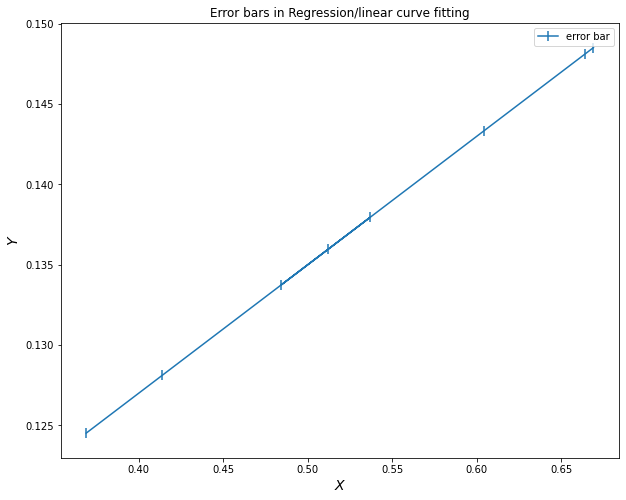

In [34]:
plt.figure(figsize = (10,8))
plt.errorbar(X, m*X+c, yerr=SE,label='error bar')
plt.title('Error bars in Regression/linear curve fitting')
plt.xlabel(f'$X$',fontsize = 14)
plt.ylabel(f'$Y$',fontsize = 14)
plt.legend()
#plt.savefig('')
plt.show()

## Uniformly distributed noise

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in double_scalars
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


Did not converge to the required precision using Gauss Siedel method. Breaking after 1000 iterations.
Cramer's rule results in c=10.32578 and m=0.97514


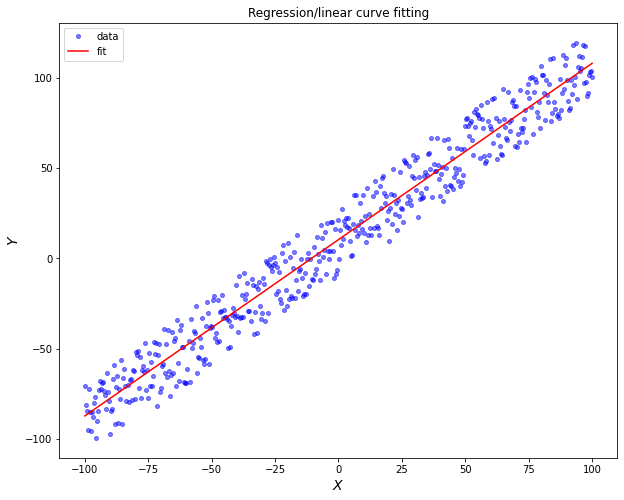

The standard error of estimate is 11.18374574227703 and the coefficient of determination is 0.96233


In [35]:
X=np.linspace(-100, 100, num=500, endpoint=True)
m_true=1 #(say)
c_true=10 #(say)
Y_true=m_true*X+c_true
y_err=np.random.uniform(low=-20, high=20, size=len(Y_true))
Y=Y_true+y_err
d=5
m,c,SE, R2=linear_fit(X,Y,d,True)   


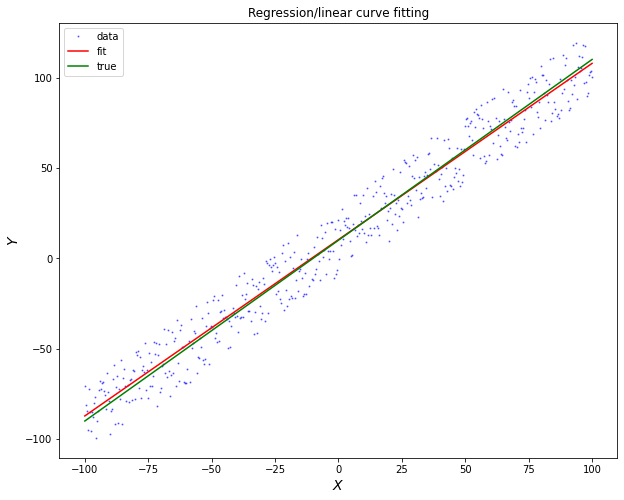

In [36]:
Y_fit=m*X+c
plt.figure(figsize = (10,8))
plt.plot(X,Y,marker='o',linestyle = '',markersize=1,color='b',label='data',alpha=0.5)
plt.plot(X,Y_fit,linestyle = '-',color='r',label='fit')
plt.plot(X,Y_true,linestyle = '-',color='g',label='true')
plt.title('Regression/linear curve fitting')
plt.xlabel(f'$X$',fontsize = 14)
plt.ylabel(f'$Y$',fontsize = 14)
plt.legend()
#plt.savefig('')
plt.show()

## Normal/Gaussian distributed noise

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in double_scalars
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


Did not converge to the required precision using Gauss Siedel method. Breaking after 1000 iterations.
Cramer's rule results in c=12.13111 and m=0.99847


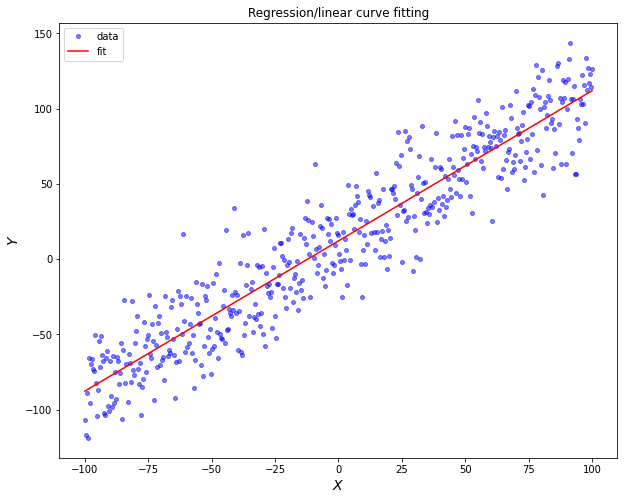

The standard error of estimate is 20.580117064951093 and the coefficient of determination is 0.88776


In [37]:
X=np.linspace(-100, 100, num=500, endpoint=True)
m_true=1 #(say)
c_true=10 #(say)
Y_true=m_true*X+c_true
y_err=np.random.normal(loc=0.0, scale=20, size=len(Y_true)) #mean=0, std dev=20
Y=Y_true+y_err
d=5
m,c,SE, R2=linear_fit(X,Y,d,True)   


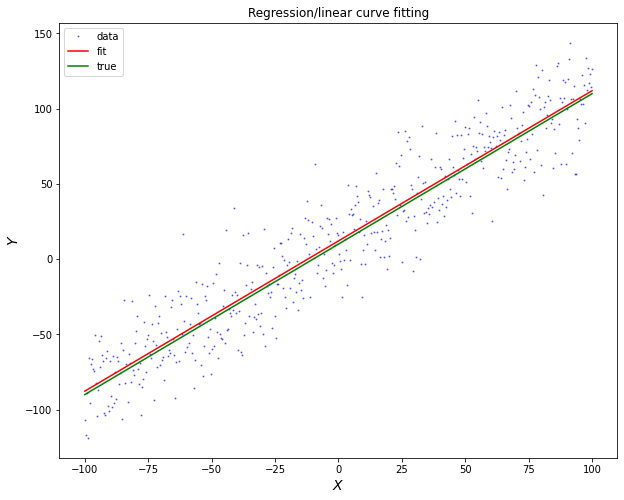

In [38]:
Y_fit=m*X+c
plt.figure(figsize = (10,8))
plt.plot(X,Y,marker='o',linestyle = '',markersize=1,color='b',label='data',alpha=0.5)
plt.plot(X,Y_fit,linestyle = '-',color='r',label='fit')
plt.plot(X,Y_true,linestyle = '-',color='g',label='true')
plt.title('Regression/linear curve fitting')
plt.xlabel(f'$X$',fontsize = 14)
plt.ylabel(f'$Y$',fontsize = 14)
plt.legend()
#plt.savefig('')
plt.show()